In [55]:
from collections import defaultdict
import json
from pathlib import Path
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from clip_layerwise_alignment.config import LOCAL_DATA_DIR, LOCAL_MODELS_DIR

In [56]:
def _check_features_matching(data_a, data_b, captions_per_image=5):
    metadata = data_a["metadata"]

    # Verify we have matching filenames for both layers
    assert (
        data_a["metadata"]["filenames"] == data_b["metadata"]["filenames"]
    ), "Metadata ordering mismatch between projected and final features!"

    # Count unique images to sample from
    n_unique_images = len(set(metadata["filenames"]))
    assert n_unique_images * captions_per_image == len(
        metadata["filenames"]
    )  # if not 5 captions per image, the sampling wont work

    return n_unique_images


def _calculate_recall_at_k(
    features_a, features_b, n_unique_images, k_value=5, 
    batch_size=256, captions_per_image=5, retrieval_mode='text'
):
    """
    Calculate Recall@K for image-text retrieval.
    
    Args:
        features_a: Projected features (e.g., text with projection)
        features_b: Target features (e.g., image final)
        n_unique_images: Number of unique images in dataset
        k_value: K value for recall@k
        batch_size: Number of unique images to sample
        captions_per_image: Number of captions per image (default 5)
        retrieval_mode: 'text' for text-to-image retrieval (query=text, gallery=images)
                       'image' for image-to-text retrieval (query=image, gallery=texts)
    
    Returns:
        Recall@K as percentage (float)
    """
    # Sample unique images
    images_idx = random.sample(range(n_unique_images), batch_size)
    features_idx = [
        (x * captions_per_image) + random.randint(0, (captions_per_image - 1)) 
        for x in images_idx
    ]

    # Get features
    projected_samples = [features_a[idx] for idx in features_idx]
    projected_batch = torch.stack(projected_samples)
    final_samples = [features_b[idx] for idx in features_idx]
    final_batch = torch.stack(final_samples)

    # Normalize
    text_norm = F.normalize(projected_batch, dim=-1)
    image_norm = F.normalize(final_batch, dim=-1)

    # Compute similarity matrix [batch_size, batch_size]
    similarities = text_norm @ image_norm.T

    if retrieval_mode == 'text':
        # Text-to-Image: For each text (row), rank images (columns)
        # Query=text, Gallery=images
        ranks = torch.argsort(similarities, dim=1, descending=True)  # [batch_size, batch_size]
        correct_indices = torch.arange(batch_size).unsqueeze(1)  # [batch_size, 1]
        top_k = ranks[:, :k_value]  # [batch_size, k]
        hits = (top_k == correct_indices).any(dim=1).float()  # [batch_size]
        
    elif retrieval_mode == 'image':
        # Image-to-Text: For each image (column), rank texts (rows)
        # Query=image, Gallery=texts
        ranks = torch.argsort(similarities, dim=0, descending=True)  # [batch_size, batch_size]
        correct_indices = torch.arange(batch_size).unsqueeze(0)  # [1, batch_size]
        top_k = ranks[:k_value, :]  # [k, batch_size]
        hits = (top_k == correct_indices).any(dim=0).float()  # [batch_size]
        
    else:
        raise ValueError(f"retrieval_mode must be 'text' or 'image', got {retrieval_mode}")

    recall = hits.mean().item() * 100  # Convert to percentage
    
    return recall

In [57]:
n_batches = 100
batch_size = 256
k_value = 1

results_folder = LOCAL_DATA_DIR / "results" / "flickr30k"

In [66]:
# =========================================
# Calculate pretrained recall
# =========================================
pretrained_recalls = []
text_final_data = torch.load(results_folder / f"text_final.pt")
text_final_embeddings = text_final_data["features"]

image_final_data = torch.load(results_folder / f"image_final.pt")
image_final_embeddings = image_final_data["features"]

temp = 0.07

n_unique_images = _check_features_matching(text_final_data, image_final_data)

for _ in range(n_batches):
    recall = _calculate_recall_at_k(
        text_final_embeddings, image_final_embeddings, n_unique_images, 
        k_value=k_value, batch_size=batch_size, retrieval_mode="image"
    )
    pretrained_recalls.append(recall)

In [60]:
# =========================================
# Calculate projection recall
# =========================================
recalls = {
    "image": defaultdict(list),  # {layer: {R@1: [val1, val2, ...], R@5: [...], ...}}
    "text": defaultdict(list),
}
for projected_encoder in ["text", "image"]:
    for L in range(1, 13):
        # Load the required embeddings + metadata
        if projected_encoder == "text":
            projected_data = torch.load(results_folder / f"text_L{L}_image_final_projected.pt")
            projected_features = projected_data["text_embeddings"]

            final_data = torch.load(results_folder / f"image_final.pt")
            final_features = final_data["features"]

            checkpoint = torch.load(LOCAL_MODELS_DIR / f"projections/text_L{L}_image_final.pt")
            inv_log_temp = checkpoint["model_state_dict"]["log_temperature"]
            temp = 1 / inv_log_temp.exp()

        else:  # projected_encoder == "image"
            projected_data = torch.load(results_folder / f"text_final_image_L{L}_projected.pt")
            projected_features = projected_data["image_embeddings"]

            final_data = torch.load(results_folder / f"text_final.pt")
            final_features = final_data["features"]

            checkpoint = torch.load(LOCAL_MODELS_DIR / f"projections/text_final_image_L{L}.pt")
            inv_log_temp = checkpoint["model_state_dict"]["log_temperature"]
            temp = 1 / inv_log_temp.exp()

        n_unique_images = _check_features_matching(final_data, projected_data)

        # Calculate recall for n_samples random batches
        for _ in range(n_batches):
            recall = _calculate_recall_at_k(
                projected_features, final_features, n_unique_images, 
                k_value=k_value, batch_size=batch_size, retrieval_mode=projected_encoder
            )

            recalls[projected_encoder][L].append(recall)

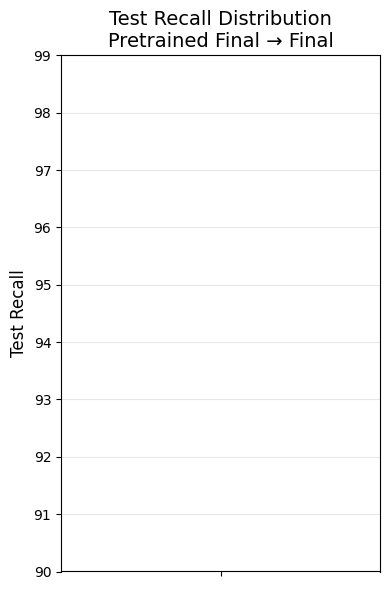

In [ ]:
def plot_pretrained_recall_distribution(
    pretrained_recalls: list,  # List of recall values
    box_color: str = '#4eb3d3',
    box_edge_color: str = '#084081',
):
    """
    Plot box plot of pretrained final×final test recalls.
    
    Args:
        pretrained_recalls: List of recall values from final×final comparisons
        box_color: Color for the box
        box_edge_color: Color for box border
    """
    fig, ax = plt.subplots(figsize=(4, 6))
    
    bp = ax.boxplot(
        [pretrained_recalls],
        positions=[1],
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor=box_color, alpha=0.7, edgecolor=box_edge_color, linewidth=1.5),
        medianprops=dict(color='black', linewidth=2),
        whiskerprops=dict(color=box_edge_color, linewidth=1.5),
        capprops=dict(color=box_edge_color, linewidth=1.5),
        flierprops=dict(marker='.', markerfacecolor=box_edge_color, markersize=8, linestyle='none'),
    )
    
    ax.set_ylabel('Test Recall', fontsize=12)
    ax.set_title('Test Recall Distribution\nPretrained Final → Final', fontsize=14)
    ax.set_xticks([1])
    ax.set_xticklabels([''])
    ax.set_ylim(90, 99)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    return fig

fig = plot_pretrained_recall_distribution(pretrained_recalls)
plt.show()

In [62]:
def plot_test_recall_distribution(
    recalls: dict,
    projected_encoder: str,  # "text" or "image"
    box_color: str = '#3498db',
    box_edge_color: str = '#2c3e50',
    mean_pretrained_recall: float = None,  # Add this parameter
):
    """
    Plot box plot of test recalls for each layer projection.
    
    Args:
        recalls: Dict with structure {encoder: {layer: [recall_1, recall_2, ...]}}
        projected_encoder: "text" or "image"
        box_color: Color for the boxes
        box_edge_color: Color for box borders
    """
    layers = sorted(recalls[projected_encoder].keys())
    recall_data = [recalls[projected_encoder][L] for L in layers]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bp = ax.boxplot(
        recall_data,
        positions=layers,
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor=box_color, alpha=0.7, edgecolor=box_edge_color, linewidth=1.5),
        medianprops=dict(color='black', linewidth=2),
        whiskerprops=dict(color=box_edge_color, linewidth=1.5),
        capprops=dict(color=box_edge_color, linewidth=1.5),
        flierprops=dict(marker='.', markerfacecolor=box_edge_color, markersize=8, linestyle='none'),
    )
    
    # Add horizontal line for pretrained baseline
    if mean_pretrained_recall is not None:
        ax.axhline(y=mean_pretrained_recall, color='black', linestyle='--', linewidth=1.5, 
                   zorder=0, label='Pretrained Final×Final')
        ax.text(min(layers), mean_pretrained_recall, f' Mean pretrained recall (final to final): {mean_pretrained_recall:.2f}', 
                va='bottom', ha='left', fontsize=10, color='black')
    
    target_encoder = "text" if projected_encoder == "image" else "image"

    target_encoder = "text" if projected_encoder == "image" else "image"
    ax.set_xlabel('Layer', fontsize=12)
    ax.set_ylabel('Test Recall', fontsize=12)
    ax.set_title(f'Test Recall Distribution: {projected_encoder.capitalize()} Encoder Layer Projections → {target_encoder.capitalize()} Final', 
                 fontsize=14)
    ax.set_xticks(layers)
    ax.set_xticklabels([f'L{L}' for L in layers])
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    return fig

In [63]:
mean_pretrained_recall = np.array(pretrained_recalls).mean()

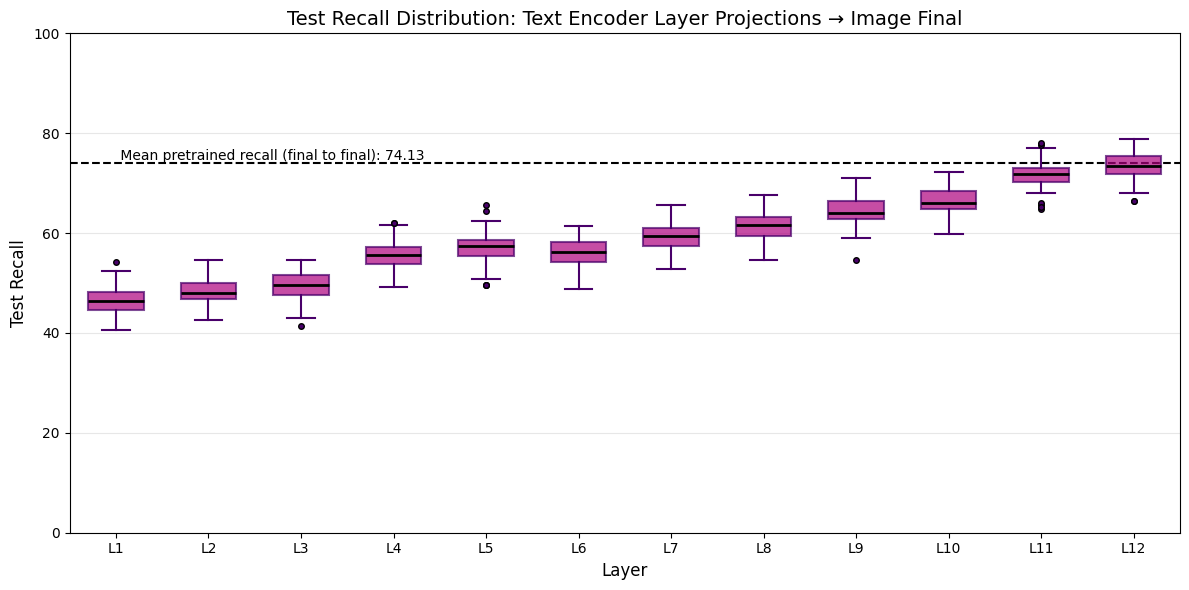

In [ ]:
fig_text = plot_test_recall_distribution(
    recalls,
    "text",
    box_color="#ae017e",
    box_edge_color="#49006a",
    mean_pretrained_recall=mean_pretrained_recall,
)

plt.show()

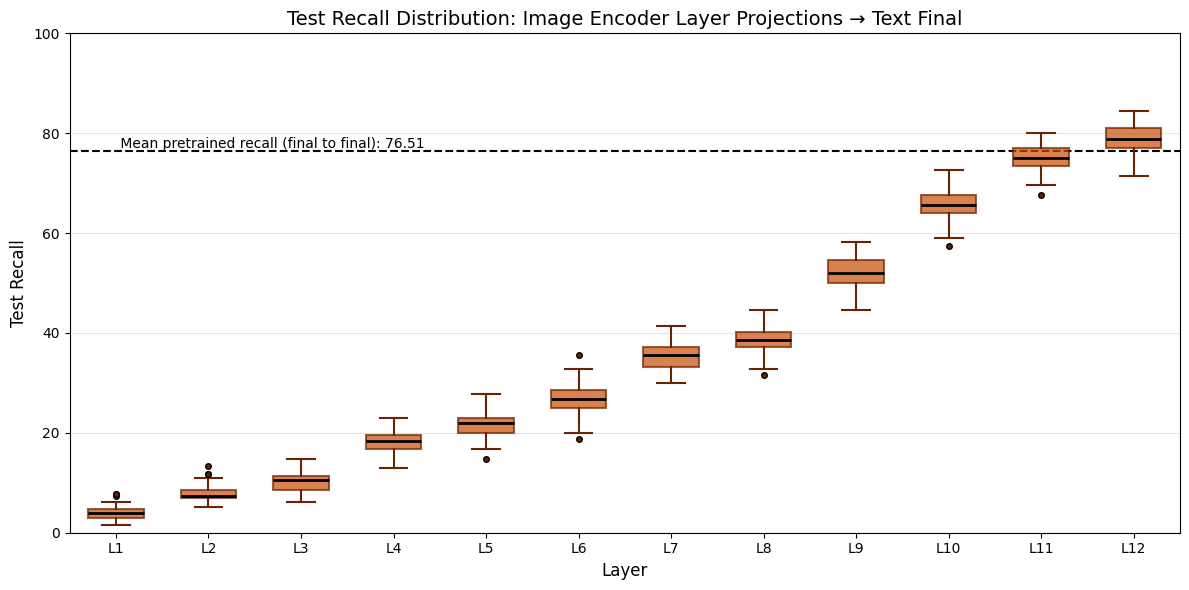

In [ ]:
mean_pretrained_recall = np.array(pretrained_recalls).mean()

fig_text = plot_test_recall_distribution(
    recalls,
    "image",
    box_color="#cc4c02",
    box_edge_color="#662506",
    mean_pretrained_recall=mean_pretrained_recall,
)
plt.show()